# For testing purposes

In [1]:
# Load the autoreload extension
%load_ext autoreload

# Enable automatic reloading of module
%autoreload 2

# Directory management

# Imports

In [2]:
import anndata
import scvi
from src.data import AnnDataManager
from src.dataloaders import AnnDataLoader
import numpy as np
import torch.nn
from src.data.fields import LayerField, CategoricalObsField, NumericalObsField
from src._multivae import MULTIVAE 
import math

import gzip
import os
import tempfile
from pathlib import Path

import numpy as np
import pooch
import scanpy as sc
import seaborn as sns
import torch

import numpy as np
import scanpy as sc
import wandb

/home/olavdc/miniforge3/envs/deeplife/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.2.2.post2


In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Data loading

In [5]:
def download_data(save_path: str, fname: str = "pbmc_10k"):
    data_paths = pooch.retrieve(
        url="https://cf.10xgenomics.com/samples/cell-arc/2.0.0/pbmc_unsorted_10k/pbmc_unsorted_10k_filtered_feature_bc_matrix.tar.gz",
        known_hash="872b0dba467d972aa498812a857677ca7cf69050d4f9762b2cd4753b2be694a1",
        fname=fname,
        path=save_path,
        processor=pooch.Untar(),
        progressbar=True,
    )
    data_paths.sort()

    for path in data_paths:
        with gzip.open(path, "rb") as f_in:
            with open(path.replace(".gz", ""), "wb") as f_out:
                f_out.write(f_in.read())

    return str(Path(data_paths[0]).parent)

In [6]:
data_path = download_data(save_dir.name)

100%|████████████████████████████████████████| 375M/375M [00:00<00:00, 703GB/s]
Untarring contents of '/tmp/tmp3_s3mxe3/pbmc_10k' to '/tmp/tmp3_s3mxe3/pbmc_10k.untar'


# Data processing

In [7]:
from src.data import read_10x_multiome
# read multiomic data
adata = read_10x_multiome(data_path)
adata.var_names_make_unique()

/home/olavdc/miniforge3/envs/deeplife/lib/python3.10/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
# split to three datasets by modality (RNA, ATAC, Multiome), and corrupt data
# by remove some data to create single-modality data
n = 4004
adata_rna = adata[:n, adata.var.modality == "Gene Expression"].copy()
adata_paired = adata[n : 2 * n].copy()
adata_atac = adata[2 * n :, adata.var.modality == "Peaks"].copy()

In [9]:
from src.data import organize_multiome_anndatas
# We can now use the organizing method from scvi to concatenate these anndata
adata_mvi = organize_multiome_anndatas(adata_paired, adata_rna, adata_atac)

/home/olavdc/github/multVI_experiments/multiVI/src/data/_preprocessing.py:334: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  return multi_anndata.concatenate(other, join="outer", batch_key=modality_key)
/home/olavdc/github/multVI_experiments/multiVI/src/data/_preprocessing.py:334: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  return multi_anndata.concatenate(other, join="outer", batch_key=modality_key)


In [10]:
adata_mvi = adata_mvi[:, adata_mvi.var["modality"].argsort()].copy()
adata_mvi.var

,ID,modality,chr,start,end
MIR1302-2HG,ENSG00000243485,Gene Expression,chr1,29553,30267
AL391261.2,ENSG00000258847,Gene Expression,chr14,66004522,66004523
FUT8-AS1,ENSG00000276116,Gene Expression,chr14,65412689,65412690
FUT8,ENSG00000033170,Gene Expression,chr14,65410591,65413008
AL355076.2,ENSG00000258760,Gene Expression,chr14,65302679,65318790
...,...,...,...,...,...
chr15:101277030-101277907,chr15:101277030-101277907,Peaks,chr15,101277030,101277907
chr15:101257856-101258771,chr15:101257856-101258771,Peaks,chr15,101257856,101258771
chr15:101251516-101252373,chr15:101251516-101252373,Peaks,chr15,101251516,101252373
chr15:101397608-101398445,chr15:101397608-101398445,Peaks,chr15,101397608,101398445


In [11]:
print(adata_mvi.shape)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))
print(adata_mvi.shape)

(12012, 148458)
(12012, 80878)


In [12]:
adata_mvi.obs["_indices"] = np.arange(adata_mvi.n_obs)

In [13]:
anndata_fields = [
    LayerField(registry_key="x", layer=None, is_count_data=True),
    CategoricalObsField(registry_key="modality", attr_key="modality"),
    NumericalObsField(registry_key  = "cell_idx", attr_key = "_indices" )
]
adata_manager = AnnDataManager(fields=anndata_fields)
adata_manager.register_fields(adata_mvi)
print(
    adata_manager.registry.keys()
)  # There is additionally a _scvi_uuid key which is used to uniquely identify AnnData objects for subsequent retrieval.

dict_keys(['scvi_version', 'model_name', 'setup_args', 'field_registries', '_scvi_uuid'])


# Splitting training and validation set

In [14]:
n_samples = adata_mvi.shape[0]
train_size = 0.9
validation_size = 0.1

n_train = math.ceil(train_size * n_samples)
n_val = n_samples - n_train

random_state = np.random.RandomState(seed=0)
indices = np.arange(adata_manager.adata.n_obs)
indices = random_state.permutation(indices)

val_idx = indices[:n_val]
train_idx = indices[n_val : (n_val + n_train)]

# Dataloader 

In [15]:
adata_mvi.obs

,batch_id,modality,_indices,_scvi_modality
barcode,,,,
CCGCTAAAGGGCCATC-0-0,1,paired,0,2
CCGCTAAAGTCTTGAA-0-0,1,paired,1,2
CCGCTAAAGTTAGACC-0-0,1,paired,2,2
CCGCTAAAGTTCCCAC-0-0,1,paired,3,2
CCGCTAAAGTTTGCGG-0-0,1,paired,4,2
...,...,...,...,...
TTTGTTGGTACGCGCA-1,1,accessibility,12007,0
TTTGTTGGTATTTGCC-1,1,accessibility,12008,0
TTTGTTGGTGATTACG-1,1,accessibility,12009,0


In [16]:
train_adl = AnnDataLoader(adata_manager, indices = train_idx, shuffle= False, drop_last= False, batch_size=128)
val_adl = AnnDataLoader(adata_manager, indices = val_idx, shuffle= False, drop_last= False, batch_size=128)

# Training

In [17]:
n_epochs = 300
n_genes = sum(adata_mvi.var.modality == "Gene Expression")
n_regions =  sum(adata_mvi.var.modality == "Peaks")
n_hidden = 128
n_latent = 11
n_epochs_kl_warmup = 50

Model

In [18]:
multivi = MULTIVAE(
    n_input_genes = n_genes,
    n_input_regions = n_regions,
    n_hidden = n_hidden,
    n_latent = n_latent,
    deeply_inject_covariates = True,
    n_batch = adata_manager.summary_stats.n_modality,
    modality_weights = "universal"
)

multivi.to(device)

/home/olavdc/miniforge3/envs/deeplife/lib/python3.10/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [19]:
import torch.optim as optim

# extract parameters of the model and adversial classifier
model_params = [param for name, param in multivi.named_parameters() if "adversarial_classifier" not in name]
adversarial_params = [param for name, param in multivi.named_parameters() if "adversarial_classifier" in name]

model_optimizer = optim.AdamW(model_params, lr=1e-4, weight_decay=1e-3, eps = 1e-08)
adversarial_optimizer = optim.Adam(adversarial_params, lr=1e-3, eps=0.01, weight_decay= 1e-3)

In [20]:
def _compute_kl_weight(
    epoch: int,
    n_epochs_kl_warmup: int | None,
    max_kl_weight: float = 1.0,
    min_kl_weight: float = 0.0,
) -> float | torch.Tensor:
    """Computes the kl weight for the current step or epoch.

    If both `n_epochs_kl_warmup` and `n_steps_kl_warmup` are None `max_kl_weight` is returned.

    Parameters
    ----------
    epoch
        Current epoch.
    step
        Current step.
    n_epochs_kl_warmup
        Number of training epochs to scale weight on KL divergences from
        `min_kl_weight` to `max_kl_weight`
    n_steps_kl_warmup
        Number of training steps (minibatches) to scale weight on KL divergences from
        `min_kl_weight` to `max_kl_weight`
    max_kl_weight
        Maximum scaling factor on KL divergence during training.
    min_kl_weight
        Minimum scaling factor on KL divergence during training.
    """
    if min_kl_weight > max_kl_weight:
        raise ValueError(
            f"min_kl_weight={min_kl_weight} is larger than max_kl_weight={max_kl_weight}."
        )

    slope = max_kl_weight - min_kl_weight
    if n_epochs_kl_warmup:
        if epoch < n_epochs_kl_warmup:
            return slope * (epoch / n_epochs_kl_warmup) + min_kl_weight
    elif n_steps_kl_warmup:
        if step < n_steps_kl_warmup:
            return slope * (step / n_steps_kl_warmup) + min_kl_weight
    return max_kl_weight

In [21]:
# Early stopping parameters

patience = 50  # Stop if no improvement for 3 epochs
min_delta = 0  # Minimum improvement required
patience_counter = 0
best_loss = float("inf")

In [22]:
wandb.init(project="multiVI-training")
run_name = wandb.run.name 
filename = f"model_weights_{run_name}.pth"

for epoch in range(n_epochs):

    train_batch_model_losses = []
    train_batch_kl_local_losses = []
    train_batch_recon_losses = []
    train_batch_elbo_losses = []

    val_batch_model_losses = []
    val_batch_kl_local_losses = []
    val_batch_recon_losses = []
    val_batch_elbo_losses = []

    # Training
    multivi.train()
    for i, batch in enumerate(train_adl):

        x = batch["x"].to(device)
        modality = batch["modality"].to(device)
        cell_idx = batch["cell_idx"].to(device)       
        y = torch.zeros(x.shape[0], 1, device=x.device, requires_grad=False).to(device) # in case of no usage of porteins 
            
        # inference
        inference_outputs = multivi.inference(x, y, modality, cell_idx)

        latent = inference_outputs["z"]
        libsize_expr = inference_outputs["libsize_expr"]
        libsize_acc = inference_outputs["libsize_acc"]
    
        # generation
        generative_outputs = multivi.generative(latent,modality,libsize_expr)

        # kl_weight & kappa
        klw = _compute_kl_weight(
            epoch = epoch,
            n_epochs_kl_warmup = n_epochs_kl_warmup,
            min_kl_weight=1e-3            
        )

        kappa = 1 

        # loss
        loss, kl_local_loss, recon_loss = multivi.loss(
            inference_outputs,
            generative_outputs,
            klw
        )
        
        n_obs_in_batch = len(kl_local_loss["kl_divergence_z"])
        kl_local_loss = (sum(kl_local_loss.values()).sum())/n_obs_in_batch
        recon_loss = (sum(recon_loss.values()).sum())/n_obs_in_batch
        elbo_loss = kl_local_loss + recon_loss

        # fool classifier by modifying z
        fool_loss = multivi.loss_adversarial_classifier(latent, modality, False)
        model_loss = loss + (fool_loss * kappa)
        model_optimizer.zero_grad()        
        model_loss.backward()
        model_optimizer.step()

        # train classifier
        adv_loss = multivi.loss_adversarial_classifier(latent.detach(), modality, True)
        adv_loss *= kappa
        adversarial_optimizer.zero_grad()
        adv_loss.backward()
        adversarial_optimizer.step()

        wandb.log({
            "train_loss_step": loss.detach(),
            "adv_train_loss": adv_loss.detach(),
            "epoch": epoch
        })
        
        train_batch_model_losses.append(loss.detach().cpu())
        train_batch_kl_local_losses.append(kl_local_loss.detach().cpu())
        train_batch_recon_losses.append(recon_loss.detach().cpu())
        train_batch_elbo_losses.append(elbo_loss.detach().cpu())
    
    train_epoch_model_loss = np.mean(train_batch_model_losses)
    train_epoch_kl_local_train = np.mean(train_batch_kl_local_losses)
    train_epoch_recon_loss = np.mean(train_batch_recon_losses)
    train_epoch_elbo_loss = np.mean(train_batch_elbo_losses)

    wandb.log({
    "train_loss_epoch": train_epoch_model_loss,
    "kl_local_train" : train_epoch_kl_local_train,
    "reconstruction_loss_train": train_epoch_recon_loss,
    "elbo_train" : train_epoch_elbo_loss,
    "epoch": epoch
})
    
    # Validation
    multivi.eval()
    with torch.no_grad():
        for i, batch in enumerate(val_adl):

            x = batch["x"].to(device)
            modality = batch["modality"].to(device)
            cell_idx = batch["cell_idx"].to(device)       
            y = torch.zeros(x.shape[0], 1, device=x.device, requires_grad=False).to(device) # in case of no usage of porteins

            # inference
            inference_outputs = multivi.inference(x, y, modality, cell_idx)

            latent = inference_outputs["z"]
            libsize_expr = inference_outputs["libsize_expr"]
            libsize_acc = inference_outputs["libsize_acc"]

            # generation
            generative_outputs = multivi.generative(latent,modality,libsize_expr)

            # kl_weight & kappa
            klw = _compute_kl_weight(
                epoch = epoch,
                n_epochs_kl_warmup = n_epochs_kl_warmup,
                min_kl_weight=1e-3            
            )

            kappa = 1 

            # loss
            loss, kl_local_loss, recon_loss = multivi.loss(
                inference_outputs,
                generative_outputs,
                klw
            )

            n_obs_in_batch = len(kl_local_loss["kl_divergence_z"])
            kl_local_loss = (sum(kl_local_loss.values()).sum())/n_obs_in_batch
            recon_loss = (sum(recon_loss.values()).sum())/n_obs_in_batch
            elbo_loss = kl_local_loss + recon_loss

            val_batch_model_losses.append(loss.detach().cpu())
            val_batch_kl_local_losses.append(kl_local_loss.detach().cpu())
            val_batch_recon_losses.append(recon_loss.detach().cpu())
            val_batch_elbo_losses.append(elbo_loss.detach().cpu())
        
    val_epoch_model_loss = np.mean(val_batch_model_losses)
    val_epoch_kl_local_train = np.mean(val_batch_kl_local_losses)
    val_epoch_recon_loss = np.mean(val_batch_recon_losses)
    val_epoch_elbo_loss = np.mean(val_batch_elbo_losses)
    
    wandb.log({
        "validation_loss": val_epoch_model_loss,
        "kl_local_validation" : val_epoch_kl_local_train,
        "reconstruction_loss_validation": val_epoch_recon_loss,
        "elbo_validation" : val_epoch_elbo_loss, 
        "epoch": epoch
        })
    
    # Early stopping
    if best_loss - val_epoch_recon_loss > min_delta:
        best_loss = val_epoch_recon_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        torch.save(multivi.state_dict(), filename)
        break  # Stop training

wandb: Currently logged in as: olav-declerck (deeplife) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Early stopping at epoch 172


# Embeddings extraction

In [59]:
anndata_fields = [
    LayerField(registry_key="x", layer=None, is_count_data=True),
    CategoricalObsField(registry_key="modality", attr_key="modality"),
    NumericalObsField(registry_key  = "cell_idx", attr_key = "_indices" )
]
adata_manager = AnnDataManager(fields=anndata_fields)
adata_manager.register_fields(adata_mvi)
print(
    adata_manager.registry.keys()
)  # There is additionally a _scvi_uuid key which is used to uniquely identify AnnData objects for subsequent retrieval.

dict_keys(['scvi_version', 'model_name', 'setup_args', 'field_registries', '_scvi_uuid'])


In [65]:
adata_mvi

AnnData object with n_obs × n_vars = 12012 × 80878
    obs: 'batch_id', 'modality', '_indices', '_scvi_modality'
    var: 'ID', 'modality', 'chr', 'start', 'end', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid'

In [67]:
total_adl = AnnDataLoader(adata_manager, shuffle= False, batch_size = 128)

In [68]:
# Extract latent space
model_to_load = "/home/olavdc/github/multVI_experiments/multiVI/model_weights_royal-river-48.pth"
multivi = MULTIVAE(
    n_input_genes = n_genes,
    n_input_regions = n_regions,
    n_hidden = n_hidden,
    n_latent = n_latent,
    deeply_inject_covariates = True,
    n_batch = adata_manager.summary_stats.n_modality,
    modality_weights = "universal"
)
multivi.load_state_dict(torch.load(model_to_load))
multivi.to(device)
multivi.eval()

latents = []

for batch in total_adl:
    
    x = batch["x"].to(device)
    modality = batch["modality"].to(device)
    cell_idx = batch["cell_idx"].to(device)       
    y = torch.zeros(x.shape[0], 1, device=x.device, requires_grad=False).to(device) # in case of no usage of porteins 
        
    # Inference
    inference_outputs = multivi.inference(x, y, modality, cell_idx)
    latent = inference_outputs["z"]
    latents += [latent.detach().cpu()]

latents = torch.cat(latents).numpy()

/tmp/ipykernel_4431/1978430329.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  multivi.load_state_dict(torch.load(model_to_load))


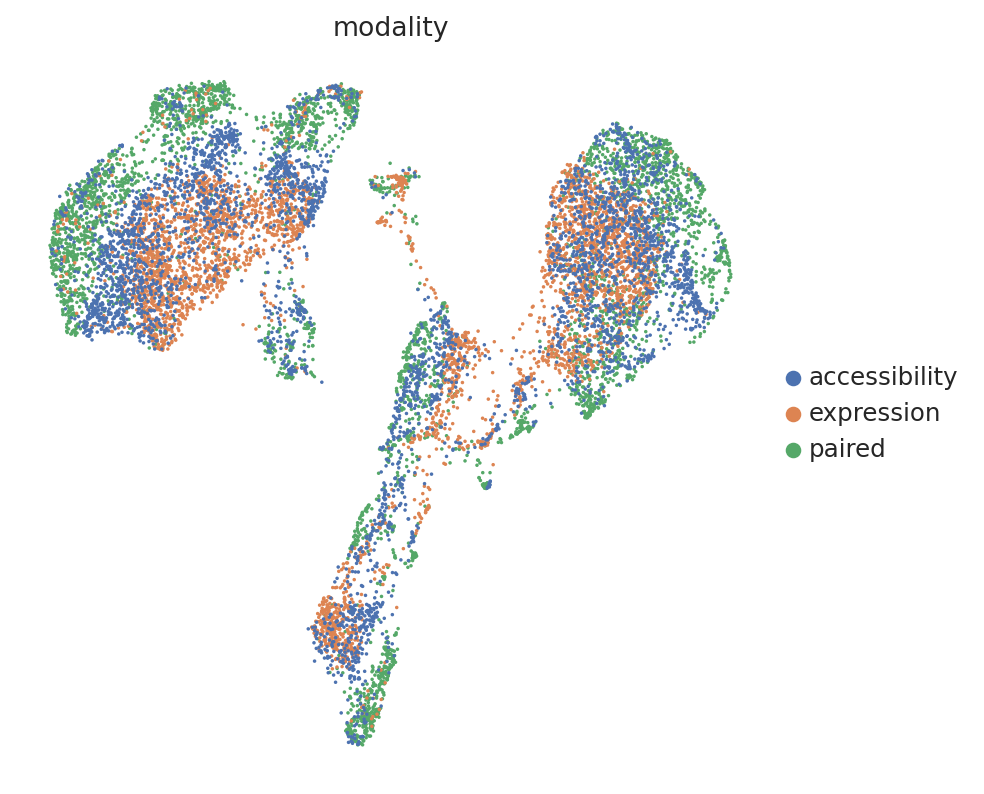

In [70]:
MULTIVI_LATENT_KEY = "X_multivi"
adata_mvi.obsm[MULTIVI_LATENT_KEY] = latents
sc.pp.neighbors(adata_mvi, use_rep=MULTIVI_LATENT_KEY)
sc.tl.umap(adata_mvi, min_dist=0.2)
sc.pl.umap(adata_mvi, color="modality")